### Load Data and Setup ###

In [1]:
#install aimodelshare library
! pip install aimodelshare --upgrade

In [2]:
#Get competition data from course folder and unzip
# importing the zipfile module
from zipfile import ZipFile
  
# loading the temp.zip and creating a zip object
with ZipFile("world_happiness_competition_data.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall()

In [3]:
# Load data
import pandas as pd
X_train = pd.read_csv('world_happiness_competition_data/X_train.csv')
X_test = pd.read_csv('world_happiness_competition_data/X_test.csv')
y_train = pd.read_csv('world_happiness_competition_data/y_train.csv')
y_train_labels = y_train.idxmax(axis=1)

X_train.head()

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks
0,Peru,0.960,1.274,0.854,0.455,0.083,0.027,Peru,Americas,Latin America and the Caribbean,18.000000
1,Nicaragua,0.694,1.325,0.835,0.435,0.200,0.127,Nicaragua,Americas,Latin America and the Caribbean,125.611111
2,Greece,1.181,1.156,0.999,0.067,0.000,0.034,Greece,Europe,Southern Europe,112.000000
3,Qatar,1.684,1.313,0.871,0.555,0.220,0.167,Qatar,Asia,Western Asia,57.333333
4,Uzbekistan,0.745,1.529,0.756,0.631,0.322,0.240,Uzbekistan,Asia,Central Asia,125.611111


### Explore bivariate results (Use visualizations!) ###
Describe any relationships you see between particular features and the target variable

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt 

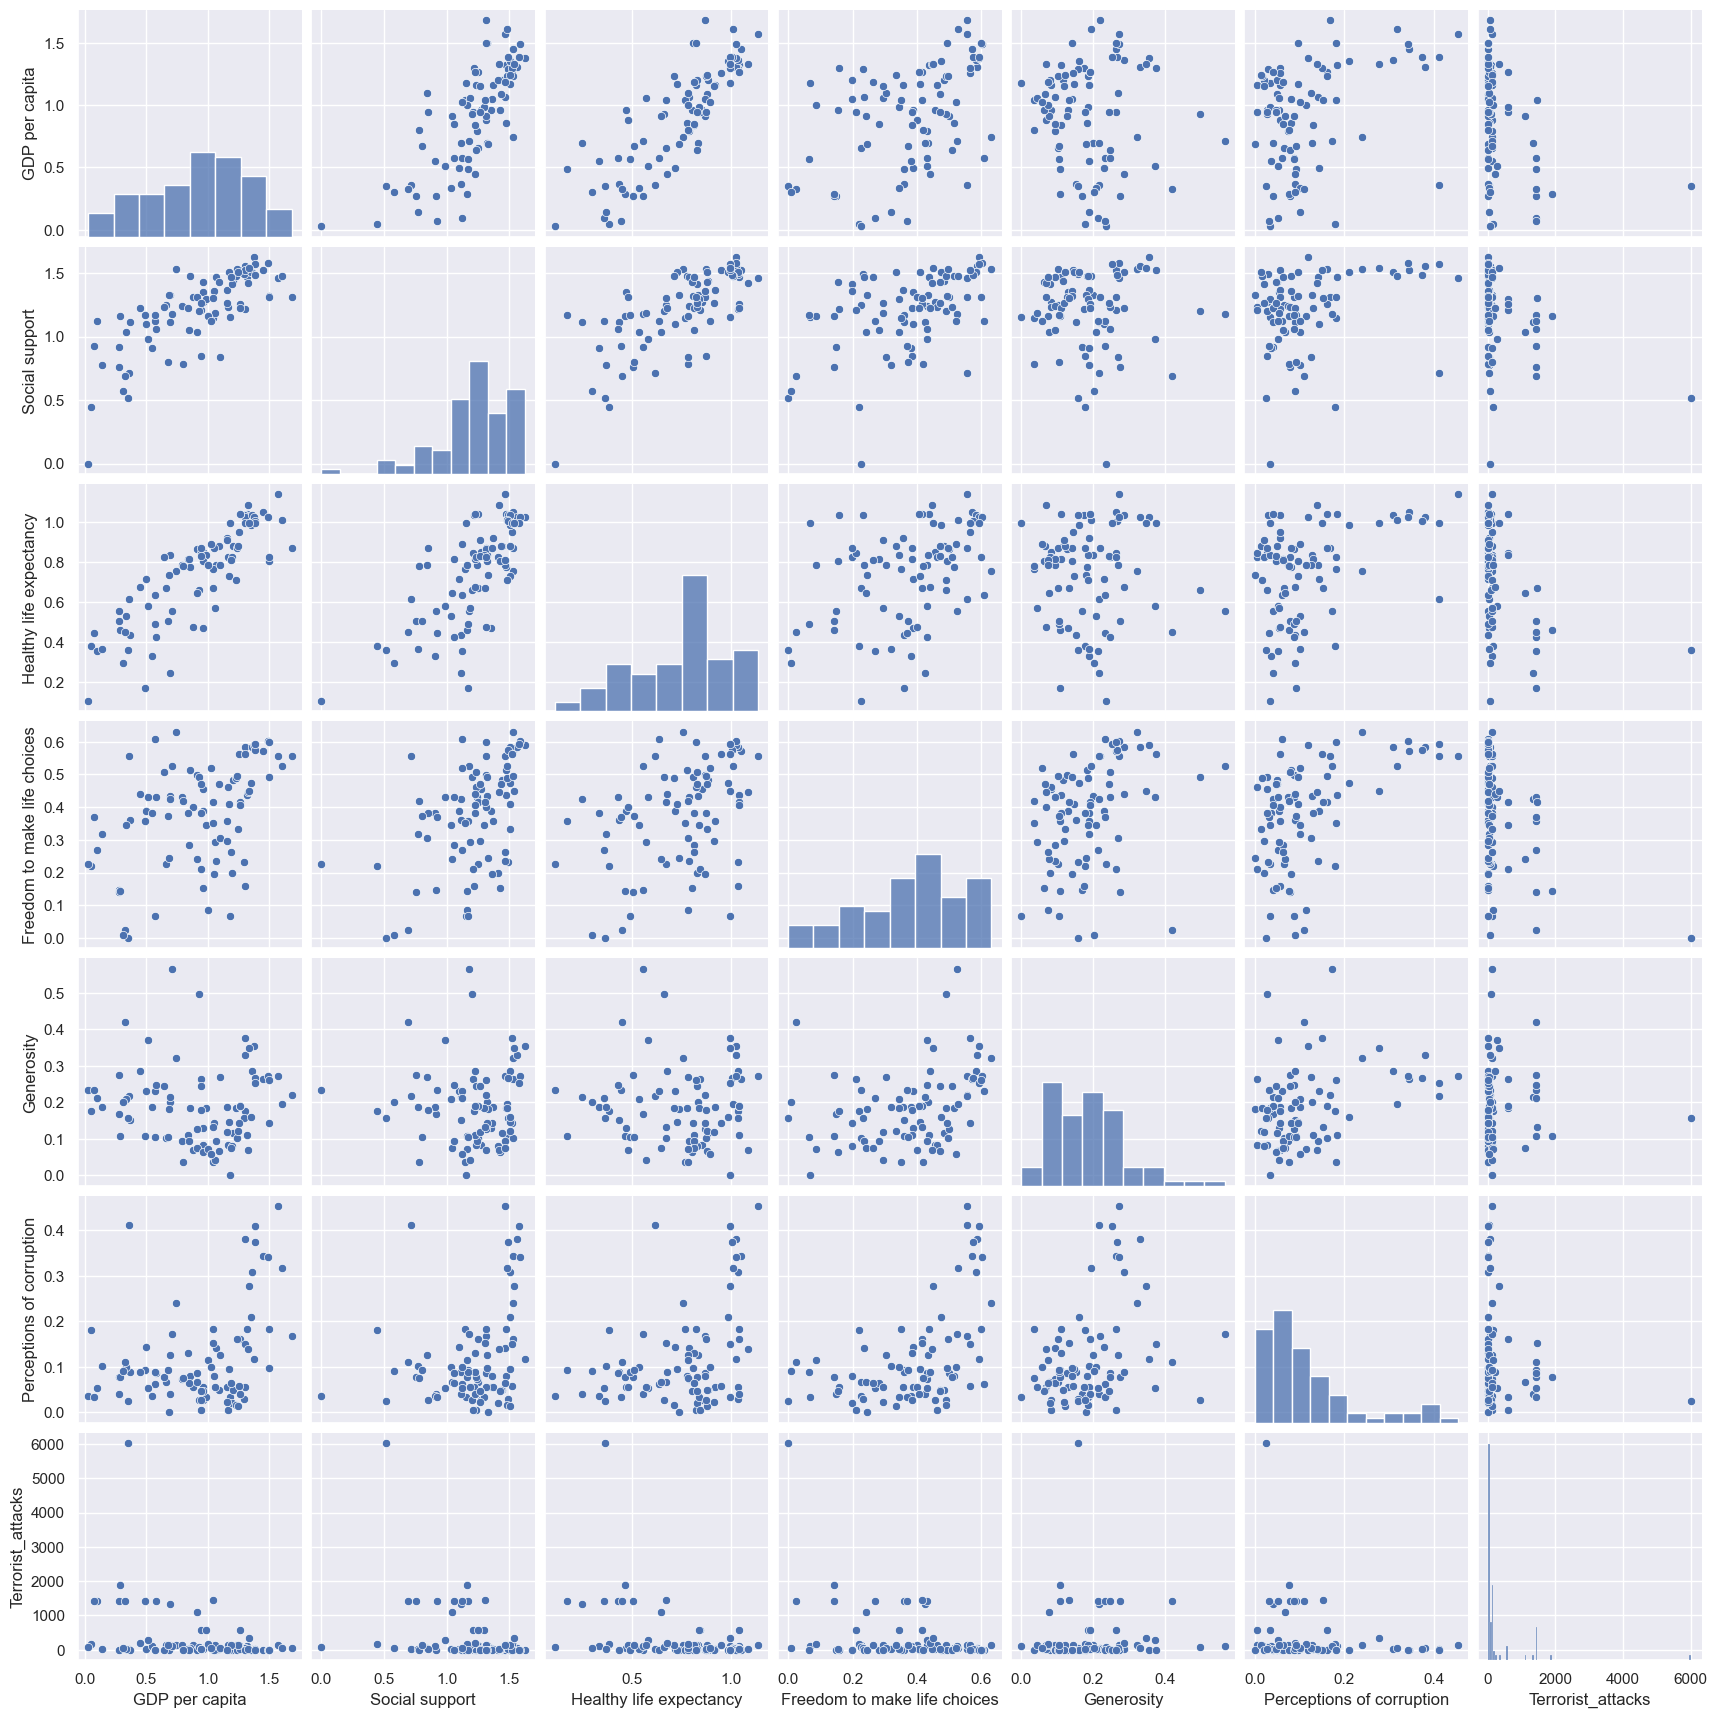

In [5]:
sns.set()
area = pd.DataFrame(X_train)

sns.pairplot(area, height = 2.5)
plt.show()

From the above graph, it can be seen that there is a strong positive relationship between GDP per capita vs. Healthy life expectancy; social support vs. Healthy life expectancy; social support vs. GDP per capita as the graphs show slope-up pattern.

### Examine features that predict happiness categories using one or more models that allow for automatic feature selection ###
Explain any meaningful findings

### Preprocess data using Sklearn ###

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# We create the preprocessing pipelines for both numeric and categorical data.

numeric_features = X_train.drop(['Country or region', 'name', 'region', 'sub-region'], axis=1)
numeric_features=numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region', 'sub-region']

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Fit your preprocessor object
preprocess=preprocessor.fit(X_train) 

In [7]:
# Write function to transform data with preprocessor

def preprocessor(data):
    data.drop(['Country or region', 'name'], axis=1)
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

In [8]:
# check shape of X data after preprocessing it using our new function
preprocessor(X_train).shape

(88, 26)

In [9]:
#Feature selection using RFE
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

estimator = LinearRegression().fit(preprocessor(X_train), y_train) #model with all X variables


selector = RFE(estimator, n_features_to_select=3, step=1) # step tells RFE how many features to remove each time model features are evaluated

selector = selector.fit(preprocessor(X_train), y_train) # fit RFE estimator.

print("Num Features: "+str(selector.n_features_))
print("Selected Features: "+str(selector.support_)) 
print("Feature Ranking: "+str(selector.ranking_))  

Num Features: 3
Selected Features: [False False False False False False False False False False False  True
 False False False False False False  True False False False False False
 False  True]
Feature Ranking: [10 24 19 23 16 21 18 22 17 13 20  1  9  6  5  4  7  3  1  2 15 11  8 12
 14  1]


In [10]:
# Transform X data for other use in this model or other models:

X_new = selector.transform(preprocessor(X_train)) #reduces X to subset identified above
X_new_test=selector.transform(preprocessor(X_test))

Using RFE we are able to eliminate to the selected three features.

### Experiment with different prediction models to try to predict World Happiness well (Fit and compare, at minimum, three models) ###
submit three models to the model share leaderboard before you start communicating with your team.
After you submit your first three models, describe your best model with your team via your team slack channel
Fit and submit up to three more models after learning from your team.
Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.
Submit your best models to the leaderboard for the World Happiness AI Model Share competition.
You have the option to present and/or discuss these models in your report, but it is not required.

In [38]:
#model 1: random forest with gridsearch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'n_estimators': np.arange(25, 50, 100),'max_depth':[1,3,5]} #np.arange creates sequence of numbers for each k value

gridmodel = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=15)

#use meta model methods to fit score and predict model:
gridmodel.fit(X_new, y_train_labels)

#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("best mean cross-validation score: {:.3f}".format(gridmodel.best_score_))
print("best parameters: {}".format(gridmodel.best_params_))


best mean cross-validation score: 0.293
best parameters: {'max_depth': 1, 'n_estimators': 25}


In [12]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


In [13]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx
from skl2onnx.common.data_types import FloatTensorType

feature_count=X_new_test.shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(gridmodel, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("gridmodel.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [14]:
#Set credentials using modelshare.org username/password

from aimodelshare.aws import set_credentials
#This is the unique rest api that powers this World Happiness Classification Playground -- make sure to update the apiurl for new competition deployments
apiurl="https://e2w6gh3id1.execute-api.us-east-2.amazonaws.com/prod/m"

set_credentials(apiurl=apiurl)

AI Modelshare Username:········
AI Modelshare Password:········
AI Model Share login credentials set successfully.


In [15]:
#Instantiate Competition
import aimodelshare as ai
mycompetition= ai.Competition(apiurl)

In [16]:
#Submit Model 1: 

#-- Generate predicted values
prediction_labels = gridmodel.predict(X_new_test)

# Submit to Competition Leaderboard
mycompetition.submit_model(model_filepath = "gridmodel.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

100% [......................................................] 1079807 / 1079807

/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

100% [........................................................] 372941 / 372941

/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 728

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [17]:
# Model 2: Gradient Boosted Classifier 
from sklearn.ensemble import GradientBoostingClassifier

model_2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,
    max_depth=5, random_state=0).fit(X_new, y_train_labels)
model_2.score(X_new, y_train_labels)

0.3181818181818182

In [18]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

feature_count=X_new_test.shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(model_2, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [19]:
#Submit Model 2: 

#-- Generate predicted y values (Model 2)
prediction_labels = model_2.predict(X_new_test)

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model2.onnx",
                                 prediction_submission=prediction_labels,
                                 preprocessor_filepath="preprocessor.zip")

100% [......................................................] 1080866 / 1080866

/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

100% [........................................................] 372941 / 372941

/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 729

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [20]:
#model 3

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD

feature_count=X_new.shape[1] #count features in input data

keras_model = Sequential()
keras_model.add(Dense(128, input_dim=feature_count, activation='relu'))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dense(5, activation='softmax')) 
                                            
# Compile model
keras_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
keras_model.fit(X_new, y_train, ## Note that keras models require a one-hot-encoded y_train object
               batch_size = 20, 
               epochs = 300, validation_split=0.25)  


Epoch 1/300
4/4 [==============================] - 1s 72ms/step - loss: 1.6105 - accuracy: 0.2121 - val_loss: 1.6101 - val_accuracy: 0.1364
Epoch 2/300
4/4 [==============================] - 0s 10ms/step - loss: 1.6095 - accuracy: 0.2879 - val_loss: 1.6103 - val_accuracy: 0.1364
Epoch 3/300
4/4 [==============================] - 0s 9ms/step - loss: 1.6087 - accuracy: 0.2879 - val_loss: 1.6106 - val_accuracy: 0.1364
Epoch 4/300
4/4 [==============================] - 0s 10ms/step - loss: 1.6080 - accuracy: 0.2879 - val_loss: 1.6111 - val_accuracy: 0.1364
Epoch 5/300
4/4 [==============================] - 0s 10ms/step - loss: 1.6076 - accuracy: 0.2879 - val_loss: 1.6115 - val_accuracy: 0.1364
Epoch 6/300
4/4 [==============================] - 0s 7ms/step - loss: 1.6066 - accuracy: 0.2879 - val_loss: 1.6120 - val_accuracy: 0.1364
Epoch 7/300
4/4 [==============================] - 0s 9ms/step - loss: 1.6059 - accuracy: 0.2879 - val_loss: 1.6128 - val_accuracy: 0.1364
Epoch 8/300
4/4 [======

4/4 [==============================] - 0s 8ms/step - loss: 1.5812 - accuracy: 0.2879 - val_loss: 1.6371 - val_accuracy: 0.1364
Epoch 60/300
4/4 [==============================] - 0s 8ms/step - loss: 1.5810 - accuracy: 0.2879 - val_loss: 1.6372 - val_accuracy: 0.1364
Epoch 61/300
4/4 [==============================] - 0s 9ms/step - loss: 1.5808 - accuracy: 0.2879 - val_loss: 1.6376 - val_accuracy: 0.1364
Epoch 62/300
4/4 [==============================] - 0s 9ms/step - loss: 1.5805 - accuracy: 0.2879 - val_loss: 1.6382 - val_accuracy: 0.1364
Epoch 63/300
4/4 [==============================] - 0s 8ms/step - loss: 1.5802 - accuracy: 0.2879 - val_loss: 1.6388 - val_accuracy: 0.1364
Epoch 64/300
4/4 [==============================] - 0s 9ms/step - loss: 1.5799 - accuracy: 0.2879 - val_loss: 1.6393 - val_accuracy: 0.1364
Epoch 65/300
4/4 [==============================] - 0s 7ms/step - loss: 1.5797 - accuracy: 0.2879 - val_loss: 1.6395 - val_accuracy: 0.1364
Epoch 66/300
4/4 [===============

4/4 [==============================] - 0s 13ms/step - loss: 1.5693 - accuracy: 0.2879 - val_loss: 1.6561 - val_accuracy: 0.1364
Epoch 118/300
4/4 [==============================] - 0s 9ms/step - loss: 1.5692 - accuracy: 0.2879 - val_loss: 1.6558 - val_accuracy: 0.1364
Epoch 119/300
4/4 [==============================] - 0s 12ms/step - loss: 1.5692 - accuracy: 0.2879 - val_loss: 1.6574 - val_accuracy: 0.1364
Epoch 120/300
4/4 [==============================] - 0s 12ms/step - loss: 1.5688 - accuracy: 0.2879 - val_loss: 1.6578 - val_accuracy: 0.1364
Epoch 121/300
4/4 [==============================] - 0s 11ms/step - loss: 1.5685 - accuracy: 0.2879 - val_loss: 1.6581 - val_accuracy: 0.1364
Epoch 122/300
4/4 [==============================] - 0s 13ms/step - loss: 1.5685 - accuracy: 0.2879 - val_loss: 1.6579 - val_accuracy: 0.1364
Epoch 123/300
4/4 [==============================] - 0s 10ms/step - loss: 1.5682 - accuracy: 0.2879 - val_loss: 1.6588 - val_accuracy: 0.1364
Epoch 124/300
4/4 [==

4/4 [==============================] - 0s 9ms/step - loss: 1.5582 - accuracy: 0.2879 - val_loss: 1.6688 - val_accuracy: 0.1364
Epoch 176/300
4/4 [==============================] - 0s 8ms/step - loss: 1.5581 - accuracy: 0.3030 - val_loss: 1.6685 - val_accuracy: 0.1364
Epoch 177/300
4/4 [==============================] - 0s 9ms/step - loss: 1.5583 - accuracy: 0.3485 - val_loss: 1.6694 - val_accuracy: 0.1364
Epoch 178/300
4/4 [==============================] - 0s 13ms/step - loss: 1.5581 - accuracy: 0.3485 - val_loss: 1.6707 - val_accuracy: 0.1364
Epoch 179/300
4/4 [==============================] - 0s 11ms/step - loss: 1.5575 - accuracy: 0.2879 - val_loss: 1.6707 - val_accuracy: 0.1364
Epoch 180/300
4/4 [==============================] - 0s 10ms/step - loss: 1.5572 - accuracy: 0.2879 - val_loss: 1.6712 - val_accuracy: 0.1364
Epoch 181/300
4/4 [==============================] - 0s 9ms/step - loss: 1.5572 - accuracy: 0.2879 - val_loss: 1.6705 - val_accuracy: 0.1364
Epoch 182/300
4/4 [=====

4/4 [==============================] - 0s 11ms/step - loss: 1.5436 - accuracy: 0.3485 - val_loss: 1.6707 - val_accuracy: 0.1364
Epoch 234/300
4/4 [==============================] - 0s 12ms/step - loss: 1.5436 - accuracy: 0.3485 - val_loss: 1.6709 - val_accuracy: 0.1364
Epoch 235/300
4/4 [==============================] - 0s 8ms/step - loss: 1.5429 - accuracy: 0.3485 - val_loss: 1.6708 - val_accuracy: 0.1364
Epoch 236/300
4/4 [==============================] - 0s 10ms/step - loss: 1.5429 - accuracy: 0.3485 - val_loss: 1.6714 - val_accuracy: 0.1364
Epoch 237/300
4/4 [==============================] - 0s 10ms/step - loss: 1.5423 - accuracy: 0.3485 - val_loss: 1.6715 - val_accuracy: 0.1364
Epoch 238/300
4/4 [==============================] - 0s 9ms/step - loss: 1.5418 - accuracy: 0.3485 - val_loss: 1.6717 - val_accuracy: 0.1364
Epoch 239/300
4/4 [==============================] - 0s 9ms/step - loss: 1.5420 - accuracy: 0.3485 - val_loss: 1.6718 - val_accuracy: 0.1364
Epoch 240/300
4/4 [====

4/4 [==============================] - 0s 10ms/step - loss: 1.5206 - accuracy: 0.3485 - val_loss: 1.6807 - val_accuracy: 0.1364
Epoch 292/300
4/4 [==============================] - 0s 12ms/step - loss: 1.5203 - accuracy: 0.3485 - val_loss: 1.6809 - val_accuracy: 0.1364
Epoch 293/300
4/4 [==============================] - 0s 11ms/step - loss: 1.5193 - accuracy: 0.3485 - val_loss: 1.6804 - val_accuracy: 0.1364
Epoch 294/300
4/4 [==============================] - 0s 8ms/step - loss: 1.5192 - accuracy: 0.3485 - val_loss: 1.6796 - val_accuracy: 0.1364
Epoch 295/300
4/4 [==============================] - 0s 12ms/step - loss: 1.5189 - accuracy: 0.3485 - val_loss: 1.6811 - val_accuracy: 0.1364
Epoch 296/300
4/4 [==============================] - 0s 13ms/step - loss: 1.5182 - accuracy: 0.3485 - val_loss: 1.6815 - val_accuracy: 0.1364
Epoch 297/300
4/4 [==============================] - 0s 13ms/step - loss: 1.5178 - accuracy: 0.3485 - val_loss: 1.6815 - val_accuracy: 0.1364
Epoch 298/300
4/4 [==

In [21]:
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(keras_model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())


/Users/moonliang/opt/anaconda3/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-02-07 11:38:10,604 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-02-07 11:38:10,909 - INFO - Signatures found in model: [serving_default].
2023-02-07 11:38:10,909 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-02-07 11:38:10,909 - INFO - Output names: ['dense_4']
2023-02-07 11:38:11,014 - INFO - Using tensorflow=2.9.2, onnx=1.12.0, tf2onnx=1.13.0/2c1db5
2023-02-07 11:38:11,014 - INFO - Using opset <onnx, 13>
2023-02-07 11:38:11,035 - INFO - Computed 0 values for constant folding
2023-02-07 11:38:11,051 - INFO - Optimizing ONNX model
2023-02-07 11:38:11,107 - INFO - After optimization: Identity -2 (2->0)
2023-02-07 11:38:11,109 - INFO - 
2023-02-07 11:3

In [22]:
# Submit keras model: 

#-- Generate predicted y values
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=keras_model.predict(X_new_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

3/3 [==============================] - 0s 2ms/step
100% [......................................................] 1083047 / 1083047

/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

100% [........................................................] 372941 / 372941

/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 731

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [55]:
data=mycompetition.compare_models([1,2,3,4,5], verbose=1)
mycompetition.stylize_compare(data)

/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/aimsonnx.py:1244: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  display(HTML(df_styled.render()))


,Model_1_Layer,Model_1_Shape,Model_1_Params
0,Dense,"[None, 64]",1728
1,Dense,"[None, 64]",4160
2,Dense,"[None, 64]",4160
3,Dense,"[None, 5]",325


/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/aimsonnx.py:1268: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  display(HTML(df_styled.render()))


,param_name,default_value,model_version_2,model_version_3,model_version_4
0,bootstrap,True,True,True,True
1,ccp_alpha,0.000000,0.000000,0.000000,0.000000
2,class_weight,None,None,None,None
3,criterion,gini,gini,gini,gini
4,max_depth,None,3,5,5
5,max_features,auto,auto,auto,auto
6,max_leaf_nodes,None,None,None,None
7,max_samples,None,None,None,None
8,min_impurity_decrease,0.000000,0.000000,0.000000,0.000000
9,min_impurity_split,None,None,None,None


,param_name,default_value,model_version_5
0,ccp_alpha,0.000000,0.000000
1,criterion,friedman_mse,friedman_mse
2,init,None,None
3,learning_rate,0.100000,1.000000
4,loss,deviance,deviance
5,max_depth,3,1
6,max_features,None,None
7,max_leaf_nodes,None,None
8,min_impurity_decrease,0.000000,0.000000
9,min_impurity_split,None,None


In [39]:
#Feature selection using RFE
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

estimator = LinearRegression().fit(preprocessor(X_train), y_train) #model with all X variables


selector = RFE(estimator, n_features_to_select=9, step=1) # step tells RFE how many features to remove each time model features are evaluated

selector = selector.fit(preprocessor(X_train), y_train) # fit RFE estimator.

print("Num Features: "+str(selector.n_features_))
print("Selected Features: "+str(selector.support_)) 
print("Feature Ranking: "+str(selector.ranking_))  

Num Features: 9
Selected Features: [False False False False False False False False False False False  True
 False  True  True  True  True  True  True  True False False False False
 False  True]
Feature Ranking: [ 4 18 13 17 10 15 12 16 11  7 14  1  3  1  1  1  1  1  1  1  9  5  2  6
  8  1]


In [40]:
# Transform X data for other use in this model or other models:

X_new2 = selector.transform(preprocessor(X_train)) #reduces X to subset identified above
X_new_test2=selector.transform(preprocessor(X_test))

In [60]:
# Model :Gradient Boosted Classifier 
from sklearn.ensemble import GradientBoostingClassifier

model_2 = GradientBoostingClassifier(n_estimators=150, learning_rate=0.5,
    max_depth=5, random_state=0).fit(X_new2, y_train_labels)
model_2.score(X_new2, y_train_labels)

0.5113636363636364

I tried three models, the Gradient boosting classifier  performed best

1. Random forest classifier with gridsearchcv: max depth [3,5,7] 'n_estimators': (300,500, 700), cv=15 best parameters: max depth=3, n_estimators: 300
2. Gradient boosting classifier with learning_rate: 0.5, max_depth: 5, n_estimators: 100, random_state: 0 (best score in my model)
3. Neural network with four layers (dense=128, 64, 64, 64 ,5) batch_size= 20, epochs= 300, validation_split= 0.25

After discussing with my team, Gradient boosting classifier seems to have the highest accuracy and I changed the number of selected features to 9, used RFE to eliminate. Then run the Gradient boosting classifier again to get the highest score. with the parameters of learning_rate: 0.5, max_depth: 5, n_estimators: 100, random_state: 0. 

In [42]:
from aimodelshare.aimsonnx import model_to_onnx

feature_count=X_new_test2.shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(model_2, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model_2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [44]:

#-- Generate predicted values
prediction_labels = model_2.predict(X_new_test2)

# Submit to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model_2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

100% [......................................................] 1091350 / 1091350

/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

100% [........................................................] 372941 / 372941

/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/Users/moonliang/opt/anaconda3/lib/python3.8/site-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 737

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [45]:
data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)
